# Step 1: Setup & Data Ingestion

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [7]:
df = pd.read_csv(r"C:\Users\alokg\Desktop\Machine Learing\ML_SaurabhSir\EndTermClustering\bank_marketing_part1_Data.csv")

In [11]:
print(df.shape)

(210, 7)


In [13]:
print(df.head())

   spending  advance_payments  probability_of_full_payment  current_balance  \
0     19.94             16.92                       0.8752            6.675   
1     15.99             14.89                       0.9064            5.363   
2     18.95             16.42                       0.8829            6.248   
3     10.83             12.96                       0.8099            5.278   
4     17.99             15.86                       0.8992            5.890   

   credit_limit  min_payment_amt  max_spent_in_single_shopping  
0         3.763            3.252                         6.550  
1         3.582            3.336                         5.144  
2         3.755            3.368                         6.148  
3         2.641            5.182                         5.185  
4         3.694            2.068                         5.837  


In [15]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   spending                      210 non-null    float64
 1   advance_payments              210 non-null    float64
 2   probability_of_full_payment   210 non-null    float64
 3   current_balance               210 non-null    float64
 4   credit_limit                  210 non-null    float64
 5   min_payment_amt               210 non-null    float64
 6   max_spent_in_single_shopping  210 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB
None


In [19]:
print(df.isnull().sum())  # Check missing values
print(df.duplicated().sum())  # Check duplicates

spending                        0
advance_payments                0
probability_of_full_payment     0
current_balance                 0
credit_limit                    0
min_payment_amt                 0
max_spent_in_single_shopping    0
dtype: int64
0


# Step 2: EDA

In [24]:
print(df.describe())

         spending  advance_payments  probability_of_full_payment  \
count  210.000000        210.000000                   210.000000   
mean    14.847524         14.559286                     0.870999   
std      2.909699          1.305959                     0.023629   
min     10.590000         12.410000                     0.808100   
25%     12.270000         13.450000                     0.856900   
50%     14.355000         14.320000                     0.873450   
75%     17.305000         15.715000                     0.887775   
max     21.180000         17.250000                     0.918300   

       current_balance  credit_limit  min_payment_amt  \
count       210.000000    210.000000       210.000000   
mean          5.628533      3.258605         3.700201   
std           0.443063      0.377714         1.503557   
min           4.899000      2.630000         0.765100   
25%           5.262250      2.944000         2.561500   
50%           5.523500      3.237000         

In [28]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')  # Example style

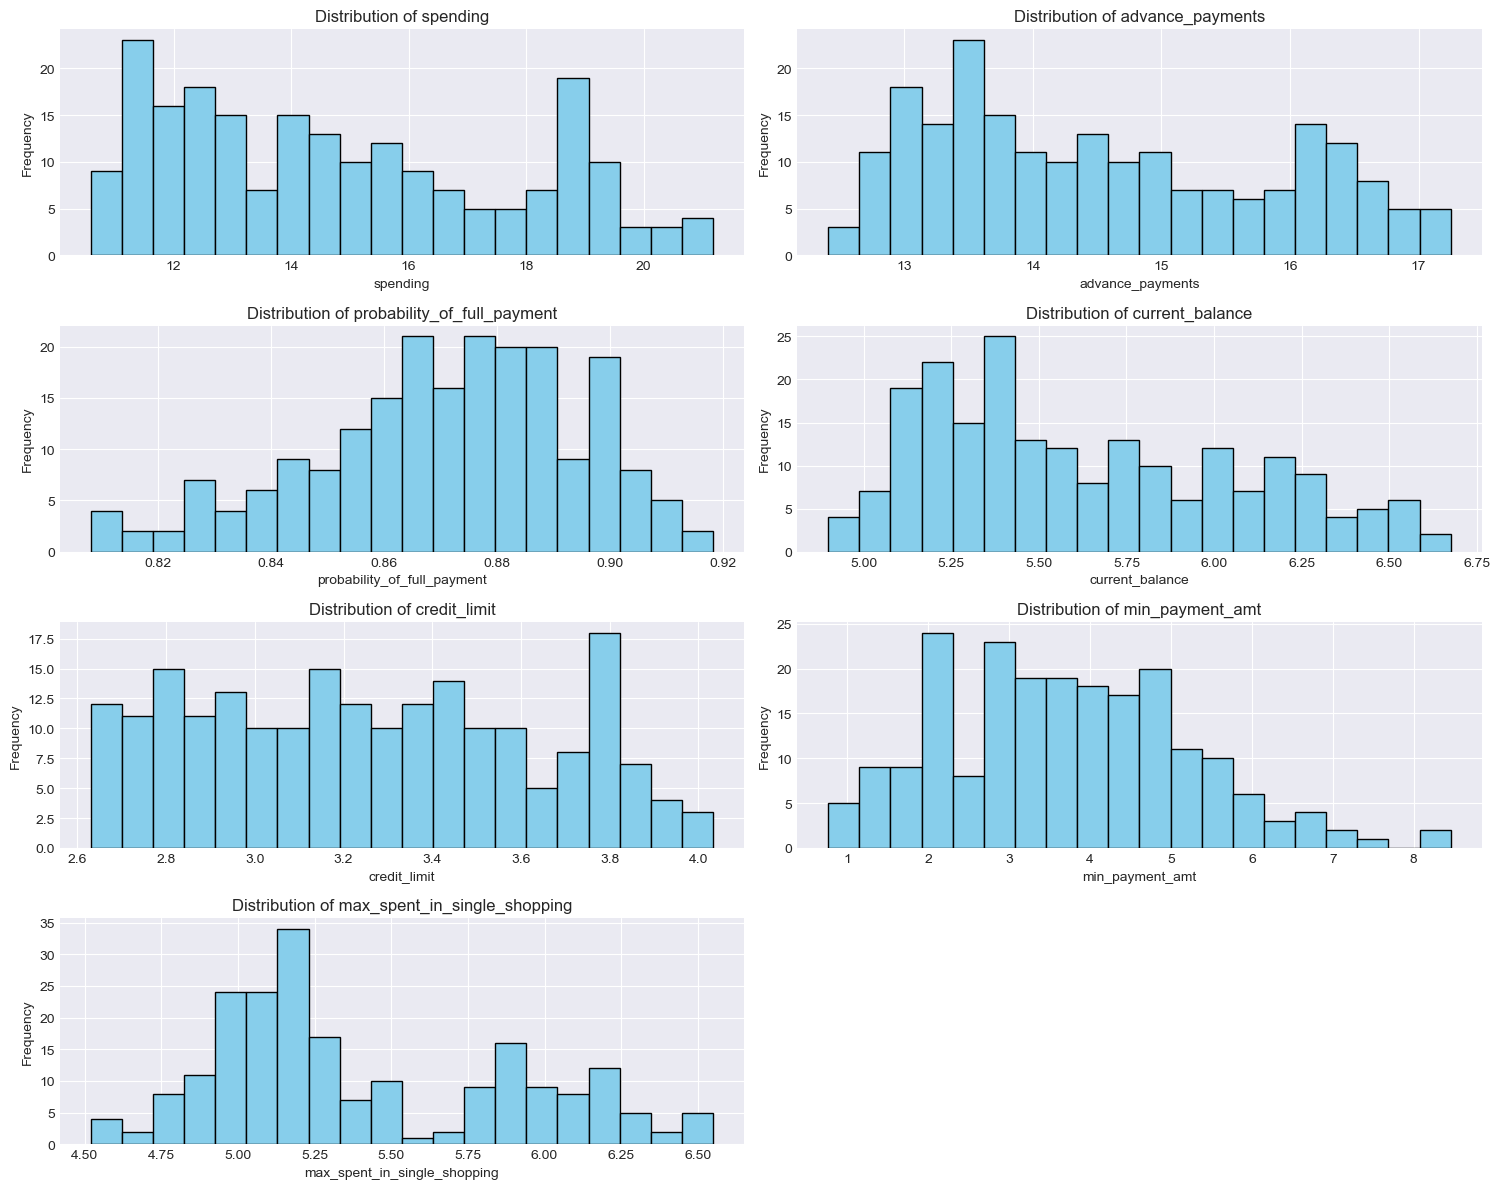

In [30]:
# Histograms for each feature
fig, axes = plt.subplots(4, 2, figsize=(15, 12))  # 4 rows, 2 cols
axes = axes.flatten()  # Flatten for easy indexing
for i, col in enumerate(df.columns):
    axes[i].hist(df[col], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
axes[-1].remove()  # Remove extra subplot (7 features, 8 slots)
plt.tight_layout()
plt.show()

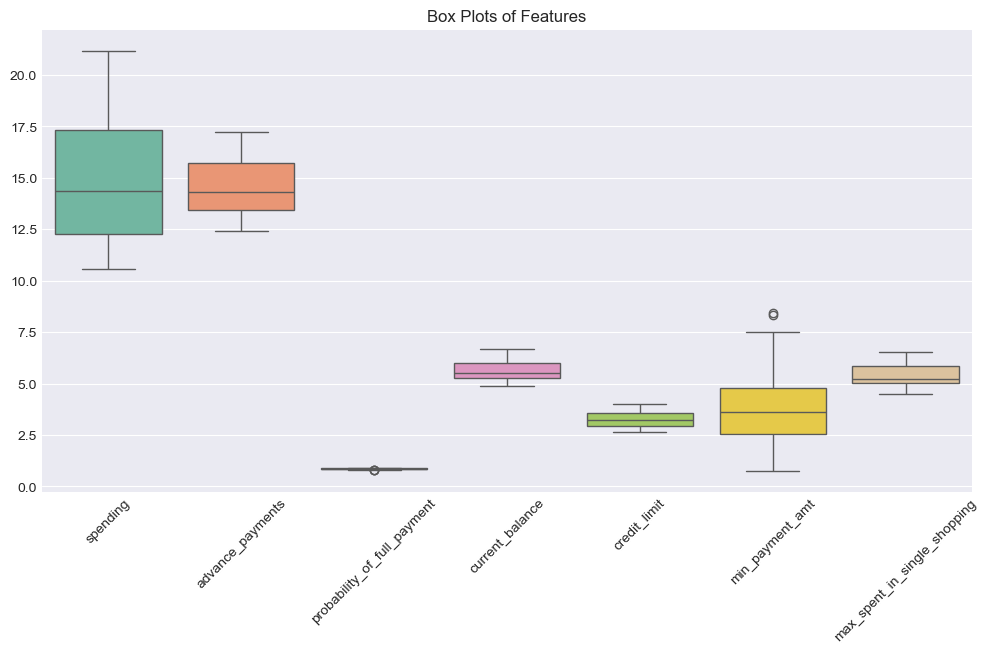

In [32]:
# Box plots for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, palette='Set2')
plt.xticks(rotation=45)
plt.title('Box Plots of Features')
plt.show()

<Figure size 1200x1000 with 0 Axes>

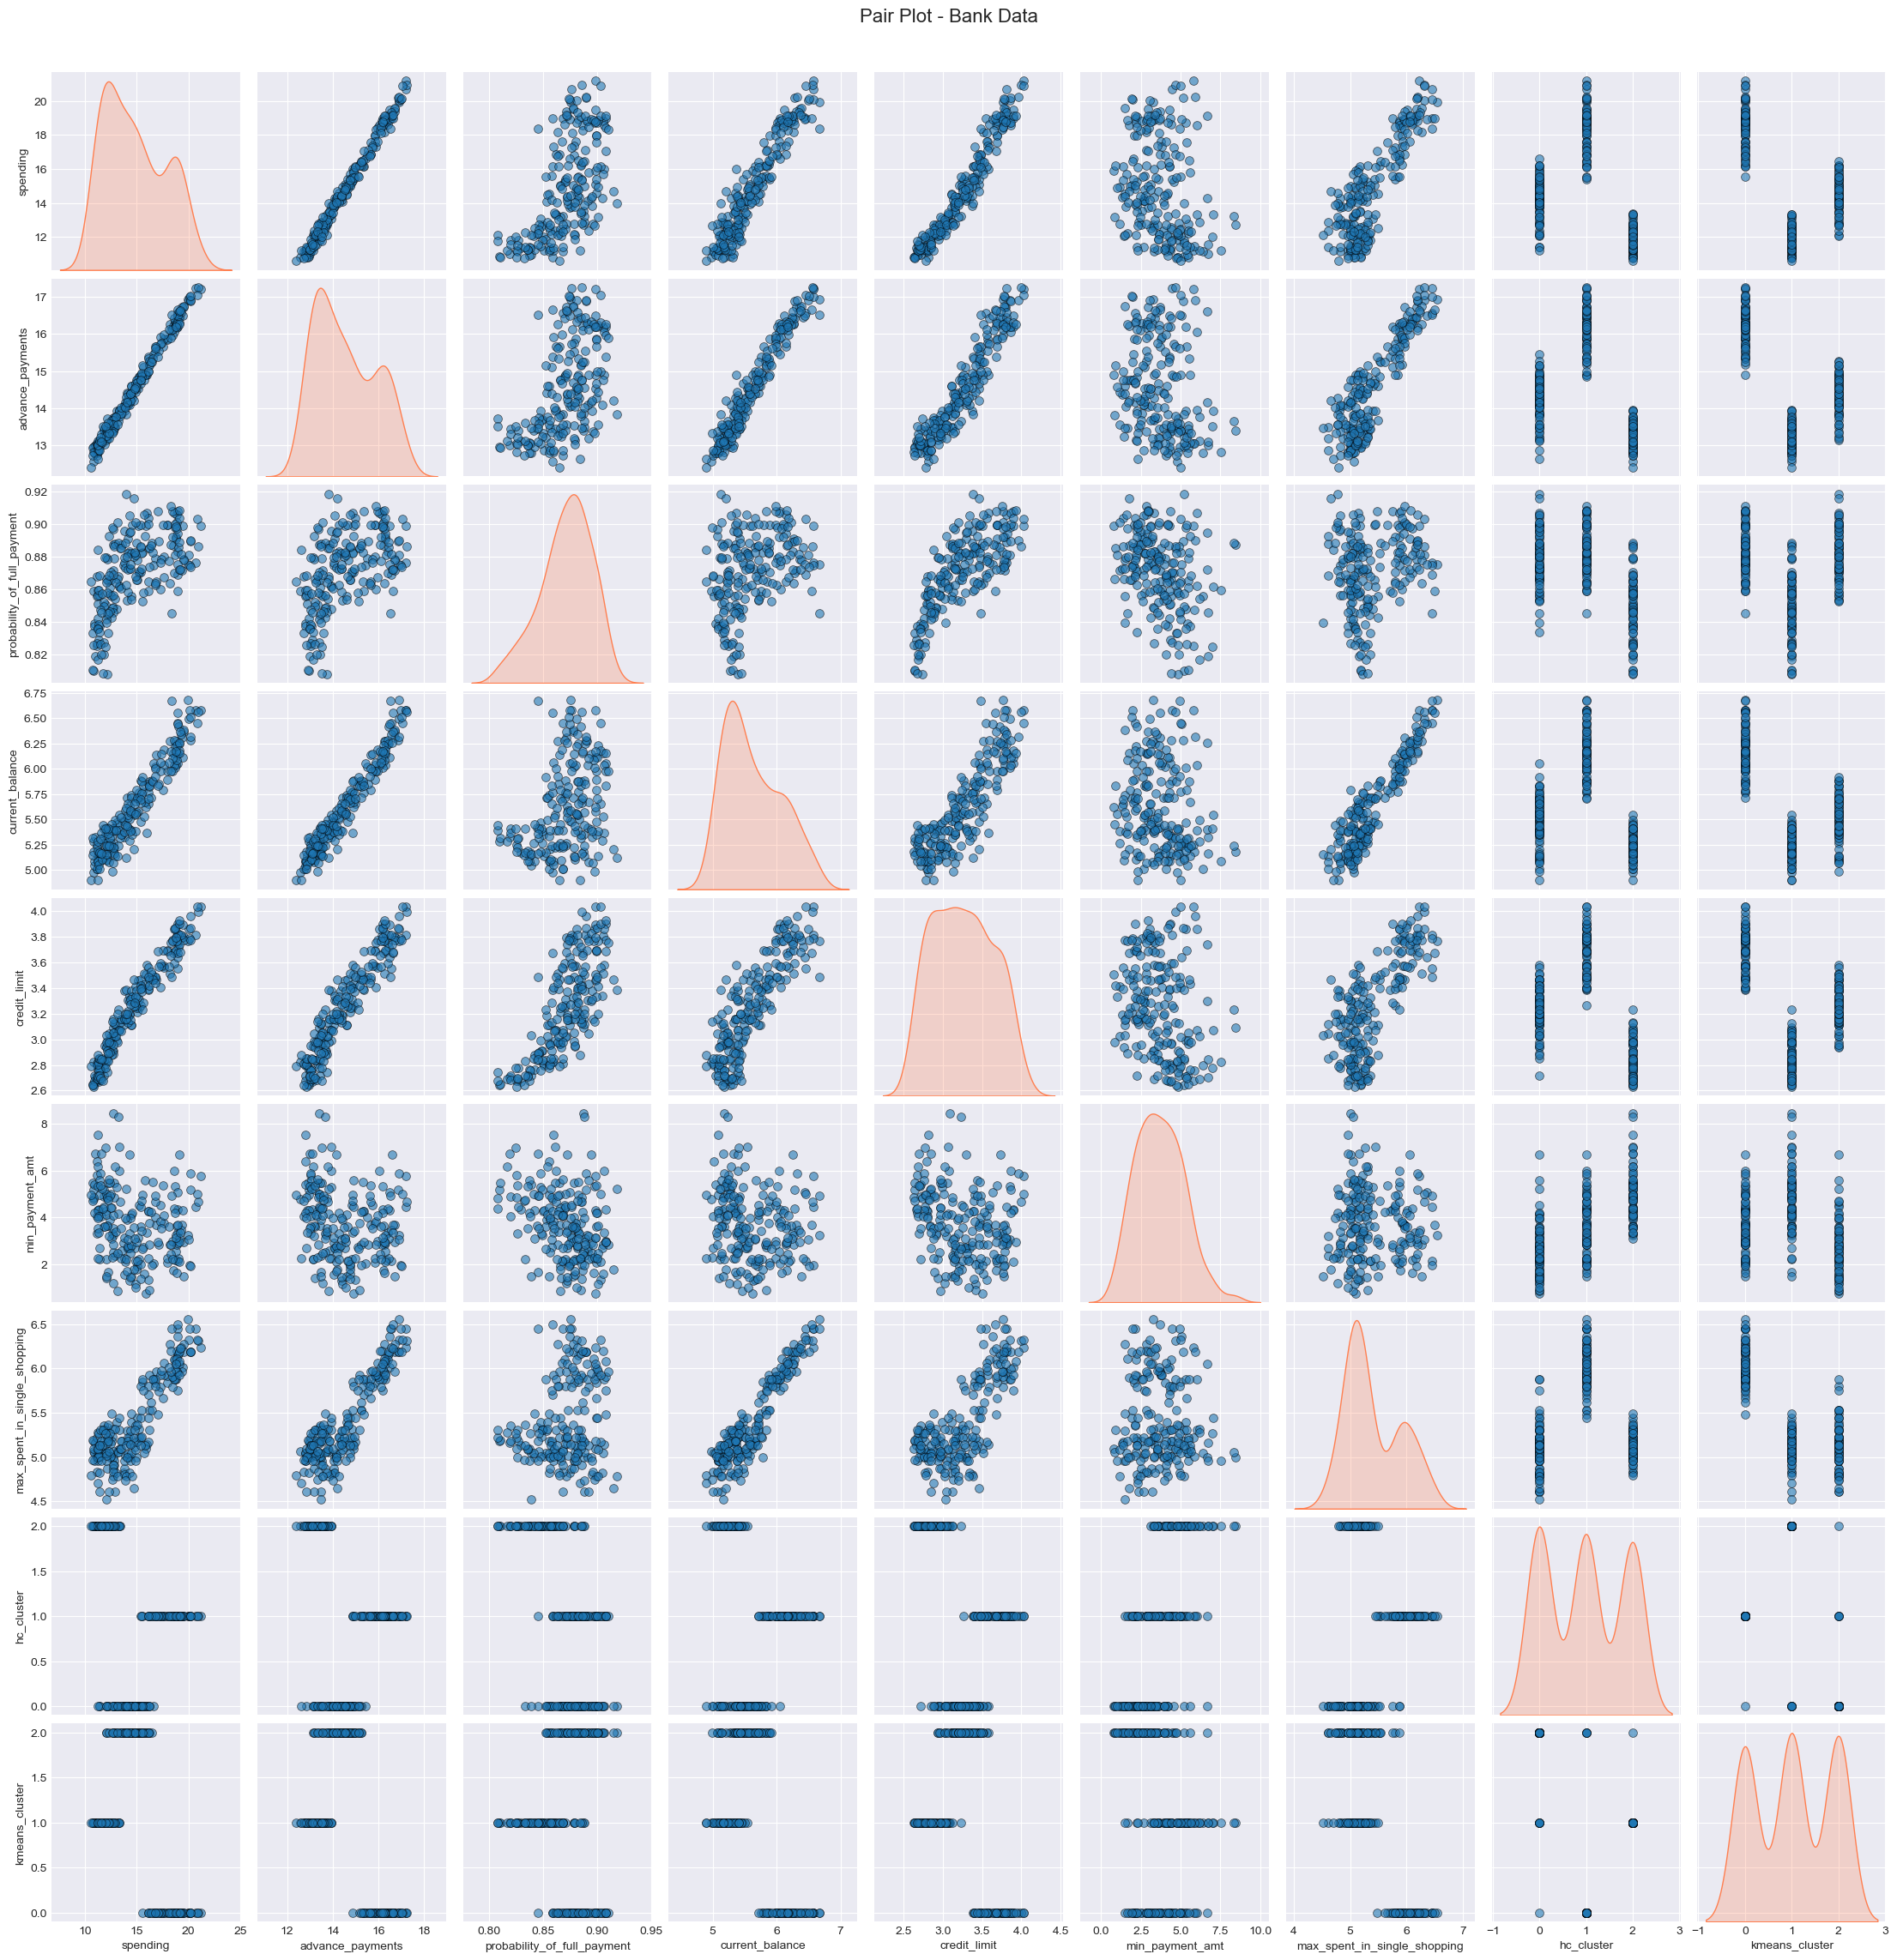

In [89]:
# Creating the pair plot
plt.figure(figsize=(12, 10))  # Adjust figure size for readability
sns.pairplot(df, 
             diag_kind='kde',  # Use kernel density estimation on diagonal
             plot_kws={'alpha': 0.6, 's': 50, 'edgecolor': 'k'},  # Customize scatter points
             diag_kws={'color': 'coral'})  # Customize diagonal KDE color

# Add a title
plt.suptitle('Pair Plot - Bank Data', y=1.02, fontsize=16)

# Display the plot
plt.show()

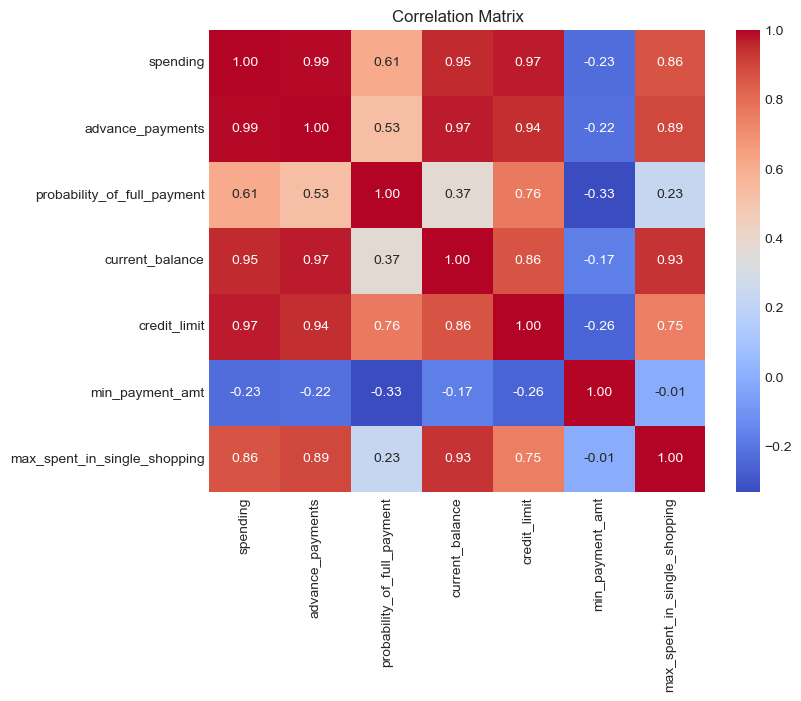

In [34]:
# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Step 3: Data Preprocessing (Scaling)

### Now that EDA confirms scaling is necessary, let’s standardize the data.

In [38]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

In [40]:
# Extract features (all columns)
X = df

In [42]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [44]:
# Convert back to DataFrame for easier handling (optional)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [46]:
print(X_scaled.mean())  # Should be ~0 for all features

spending                        9.008667e-16
advance_payments                1.184238e-16
probability_of_full_payment     1.243450e-15
current_balance                -1.057355e-16
credit_limit                   -3.267228e-16
min_payment_amt                 5.244482e-16
max_spent_in_single_shopping   -1.937075e-15
dtype: float64


In [48]:
print(X_scaled.std())   # Should be ~1 for all features

spending                        1.002389
advance_payments                1.002389
probability_of_full_payment     1.002389
current_balance                 1.002389
credit_limit                    1.002389
min_payment_amt                 1.002389
max_spent_in_single_shopping    1.002389
dtype: float64


# Step 4: Hierarchical Clustering

In [51]:
# Import necessary libraries for hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [53]:
# Step 4.1: Compute the linkage matrix for hierarchical clustering
Z = linkage(X_scaled, method='ward')

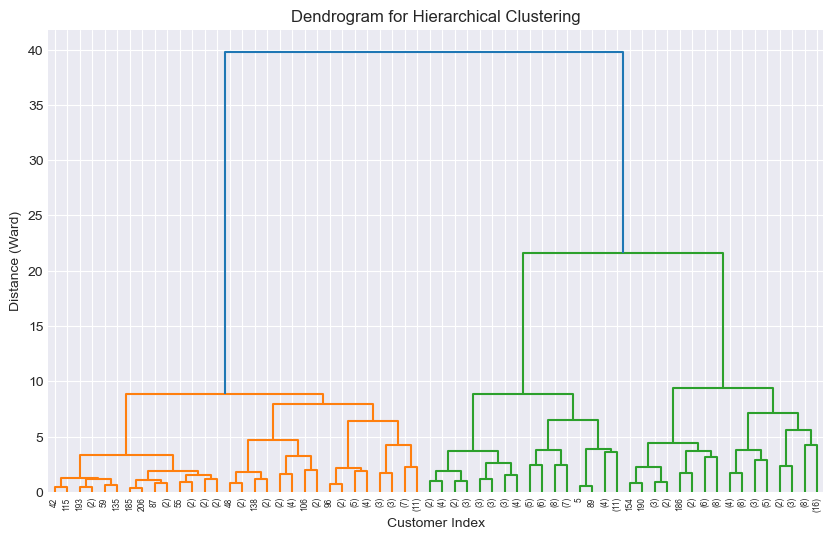

In [55]:
# Step 4.2: Plot the dendrogram to determine the number of clusters
plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode='level', p=5)  # Show up to 5 levels for clarity
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Customer Index')
plt.ylabel('Distance (Ward)')
plt.show()

In [57]:
# Step 4.3: Fit hierarchical clustering with a chosen number of clusters
# (We'll choose n_clusters based on the dendrogram; for now, let's assume 3)
n_clusters_hc = 3  # Adjust this after inspecting the dendrogram
hc = AgglomerativeClustering(n_clusters=n_clusters_hc, linkage='ward')
hc_labels = hc.fit_predict(X_scaled)

In [59]:
# Step 4.4: Add cluster labels to the original DataFrame
df['hc_cluster'] = hc_labels

In [61]:
# Step 4.5: Analyze clusters by computing mean feature values for each cluster
hc_cluster_means = df.groupby('hc_cluster').mean()
print("Hierarchical Clustering - Cluster Means:")
print(hc_cluster_means)

Hierarchical Clustering - Cluster Means:
             spending  advance_payments  probability_of_full_payment  \
hc_cluster                                                             
0           14.199041         14.233562                     0.879190   
1           18.371429         16.145429                     0.884400   
2           11.872388         13.257015                     0.848072   

            current_balance  credit_limit  min_payment_amt  \
hc_cluster                                                   
0                  5.478233      3.226452         2.612181   
1                  6.158171      3.684629         3.639157   
2                  5.238940      2.848537         4.949433   

            max_spent_in_single_shopping  
hc_cluster                                
0                               5.086178  
1                               6.017371  
2                               5.122209  


In [63]:
# Step 4.6: Compute silhouette score to evaluate clustering quality
hc_silhouette = silhouette_score(X_scaled, hc_labels)
print(f"Hierarchical Clustering Silhouette Score: {hc_silhouette:.3f}")

Hierarchical Clustering Silhouette Score: 0.393


# Step 5: K-Means Clustering

In [66]:
# Step 5.1: Elbow Method to find optimal number of clusters
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

C:\Users\alokg\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alokg\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alokg\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alokg\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

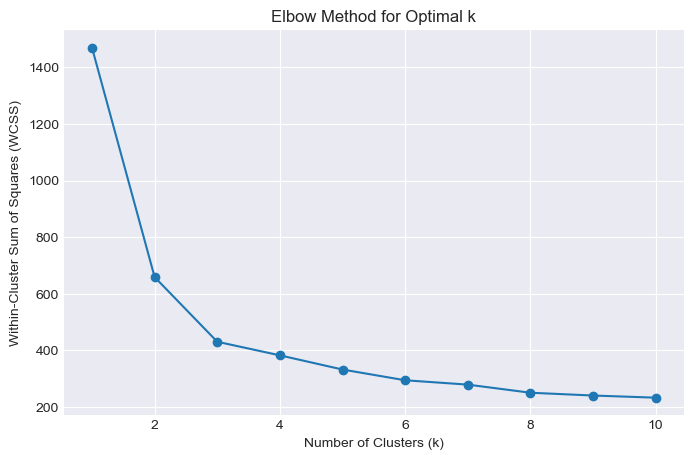

In [68]:
# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

In [70]:
# Step 5.2: Silhouette Analysis for k=2 to 10
sil_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

C:\Users\alokg\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alokg\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alokg\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alokg\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

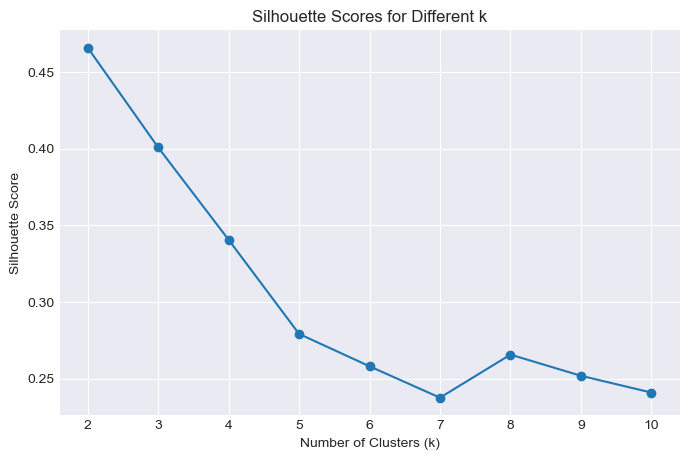

In [72]:
# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), sil_scores, marker='o')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [74]:
# Step 5.3: Fit K-means with the optimal k (choose based on elbow and silhouette)
# For now, let's assume k=3 (we'll adjust after seeing the plots)
optimal_k = 3  # Adjust this after inspecting the plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

C:\Users\alokg\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [76]:
# Step 5.4: Add cluster labels to the DataFrame
df['kmeans_cluster'] = kmeans_labels

In [78]:
# Step 5.5: Analyze clusters by computing mean feature values
kmeans_cluster_means = df.groupby('kmeans_cluster').mean()
print("K-Means Clustering - Cluster Means:")
print(kmeans_cluster_means)

K-Means Clustering - Cluster Means:
                 spending  advance_payments  probability_of_full_payment  \
kmeans_cluster                                                             
0               18.495373         16.203433                     0.884210   
1               11.856944         13.247778                     0.848253   
2               14.437887         14.337746                     0.881597   

                current_balance  credit_limit  min_payment_amt  \
kmeans_cluster                                                   
0                      6.175687      3.697537         3.632373   
1                      5.231750      2.849542         4.742389   
2                      5.514577      3.259225         2.707341   

                max_spent_in_single_shopping  hc_cluster  
kmeans_cluster                                            
0                                   6.041701    0.985075  
1                                   5.101722    1.833333  
2               

In [80]:
# Step 5.6: Compute silhouette score for K-means
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
print(f"K-Means Clustering Silhouette Score: {kmeans_silhouette:.3f}")

K-Means Clustering Silhouette Score: 0.401


In [82]:
# Ensure K-means labels are in the DataFrame
print("K-Means Cluster Labels in DataFrame:")
print(df['kmeans_cluster'].value_counts())  # Check how many customers per cluster

# Compute and display cluster means
kmeans_cluster_means = df.groupby('kmeans_cluster').mean()
print("K-Means Clustering - Cluster Means:")
print(kmeans_cluster_means)

K-Means Cluster Labels in DataFrame:
kmeans_cluster
1    72
2    71
0    67
Name: count, dtype: int64
K-Means Clustering - Cluster Means:
                 spending  advance_payments  probability_of_full_payment  \
kmeans_cluster                                                             
0               18.495373         16.203433                     0.884210   
1               11.856944         13.247778                     0.848253   
2               14.437887         14.337746                     0.881597   

                current_balance  credit_limit  min_payment_amt  \
kmeans_cluster                                                   
0                      6.175687      3.697537         3.632373   
1                      5.231750      2.849542         4.742389   
2                      5.514577      3.259225         2.707341   

                max_spent_in_single_shopping  hc_cluster  
kmeans_cluster                                            
0                               

In [84]:
print("Hierarchical Cluster Sizes:")
print(df['hc_cluster'].value_counts())

Hierarchical Cluster Sizes:
hc_cluster
0    73
1    70
2    67
Name: count, dtype: int64


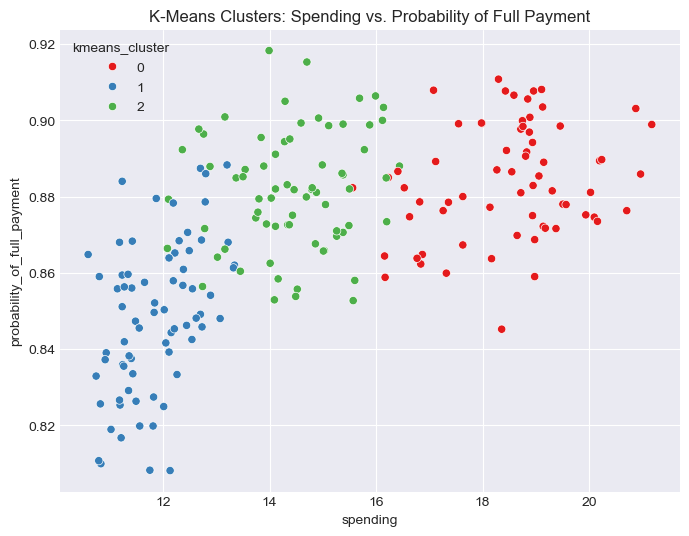

In [86]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='spending', y='probability_of_full_payment', hue='kmeans_cluster', data=df, palette='Set1')
plt.title('K-Means Clusters: Spending vs. Probability of Full Payment')
plt.show()